# Covid-19: From model prediction to model predictive control

## Calibration of the age-stratified deterministic model (1)

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook was made to quickly perform scenario analysis with the age-stratified model implementation.

### Load required packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
import datetime
import scipy
from scipy.integrate import odeint
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st
import networkx # to install networkx in your environment: conda install networkx
from covid19model.models import models
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import polymod
from covid19model.data import parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2
import math
import xarray as xr
import emcee
from covid19model.optimization import objective_fcns
from covid19model.optimization import MCMC

### Load interaction matrices

In [3]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = polymod.get_interaction_matrices()
levels = initN.size

In [4]:
params = parameters.get_COVID19_SEIRD_parameters()
params.update({'k': 1, 't0': 1})
initial_states = {'S': initN, 'E': np.ones(levels)}
model = models.COVID19_SEIRD(initial_states, params)

### Load parameter values, remove deterministic parameter, add compliance function parameters and intialise a stochastic model

In [5]:
params = parameters.get_COVID19_SEIRD_parameters()
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#some required parameters are different, the 'parameter loading function' must be changed in the future
params.update({'beta':0.035,
               'k':   1,
               't0':5,
               'Nc': Nc_total})
del params['totalTests']
del params['dq']
del params['psi_FP']
del params['psi_PP']
initial_states = {'S': initN, 'E': np.ones(levels)}
model_sto = models.COVID19_SEIRD_sto(initial_states, params,discrete=True)

### Scrape high-level Sciensano data

In [6]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano.head()

,H_tot,ICU_tot,H_in,H_out,H_tot_cumsum
DATE,,,,,
2020-03-15,266,54,71,18,53
2020-03-16,370,79,90,14,129
2020-03-17,497,100,123,31,221
2020-03-18,650,131,183,48,356
2020-03-19,844,165,212,49,519


### Calibrating $\beta$ and lag_time

**Skip this section when parameters were previously calibrated**

Use the function fit_pso to obtain a good first estimate for the MCMC sampler.

In [8]:
# define dataset
data=[df_sciensano["H_in"].values[:7]]
# set optimisation settings
parNames = ['sigma_H_in','extraTime','beta'] # must be a list!
states = [["H_in"]]
bounds=((1,15),(32,48),(0.03,0.055)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,maxiter=50,popsize=50)

No constraints given.
Best after iteration 1: [1.15955322e+01 3.83148689e+01 3.72445768e-02] 25.69731981243379
Best after iteration 2: [1.15955322e+01 3.83148689e+01 3.72445768e-02] 25.69731981243379


Process ForkPoolWorker-11:
Process ForkPoolWorker-6:
Process ForkPoolWorker-10:
Process ForkPoolWorker-5:
Process ForkPoolWorker-1:
Process ForkPoolWorker-8:
Process ForkPoolWorker-9:
Process ForkPoolWorker-7:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)


In [7]:
lag_time = int(round(theta[1]))
model.extraTime = int(round(theta[1]))

model.parameters.update({
    'beta': theta[2],
}
)

start_date = '15-03-2020'

Initiatize and run the MCMC sampler

In [8]:
parNames = ['sigma_ICU','beta'] # must be a list!
states = [["ICU"]]
bounds=((1,100),(0.01,0.10))

pos = [theta[0],theta[2]] + [5, 1e-2 ]* np.random.randn(4, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [23:20<00:00,  3.57it/s]


In [9]:
samples = sampler.get_chain(discard=100,flat=False)
flat_samples = sampler.get_chain(discard=100,flat=True)

In [10]:
sampler.get_autocorr_time()

array([55.74292369, 39.51487686])

In [11]:
mean = np.mean(flat_samples[:,1])
p10 = np.percentile(flat_samples[:,1],10)
p90 = np.percentile(flat_samples[:,1],90)
print(mean,p10,p90)

0.037688389837820795 0.037483043296351846 0.03788686979236626


Initialize a dictionary of samples and write them to `parameters.json`

In [13]:
samples_dict={'lag_time': int(round(theta[1])), 'beta': flat_samples[:,1].tolist()}

In [14]:
import json

with open('parameters.json', 'w') as fp:
    json.dump(samples_dict, fp)

Make some diagnostic visualisations

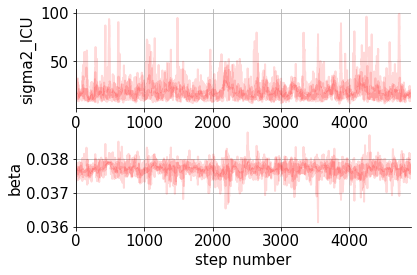

In [15]:
traceplot(samples,labels=["sigma2_ICU","beta"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

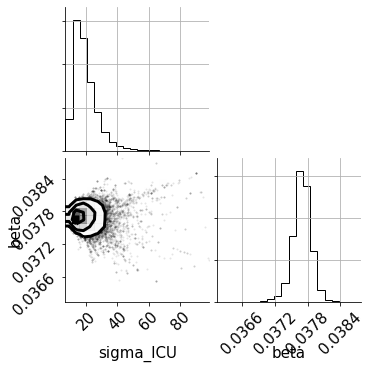

In [16]:
import corner

fig = corner.corner(
    flat_samples, labels=['sigma_ICU','beta'],
);

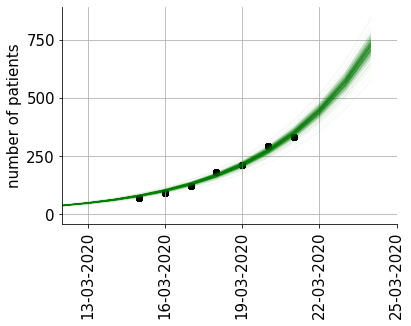

In [17]:
T = 3
fig,ax=plt.subplots()
for i in range(400):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    y_model = model.sim(data[0].size+lag_time-1+T)
    ax = plot_fit(y_model,data,start_date,lag_time,states,T=T,ax=ax,plt_kwargs={'linewidth': 0.25,'alpha': 0.10})

### Calibrating the compliance function parameters k and t0

#### Loading $\beta$ and lag_time

Load the previously calibrated parameters.

In [6]:
import json
with open('parameters.json', 'r') as fp:
    samples_dict = json.load(fp)

lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])

#### Initial guess for MCMC with PSO

In [13]:
# Create checkpoints dictionary
chk = {'time':  [lag_time], 
       'Nc':    [0.2*Nc_home + ((1-0.70)*Nc_work + (1-0.80)*Nc_transport)],
      }

# define dataset
data=[df_sciensano["H_in"].values[:37]]
# set optimisation settings
parNames = ['sigma_H_in','k','t0','prevention'] # must be a list!
states = [["H_in"]]
bounds=((1,100),(0.2,2),(1,20),(0.1,1)) # must be a list!
# run optimisation
#theta = MCMC.fit_pso(model,data,parNames,states,bounds,checkpoints=chk,maxiter=100,popsize=50)

In [11]:
model.parameters.update({
    'k': theta[1],
    't0': theta[2]
}
)
prevention = theta[3]
# Create checkpoints dictionary
chk = {'time':  [lag_time], 
       'Nc':    [0.2*Nc_home + prevention*((1-0.70)*Nc_work + (1-0.80)*Nc_transport)],
      }

In [14]:
pos = theta + [1, 1e-1, 1e-1, 1e-1 ]* np.random.randn(8, 4)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,chk))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [1:07:14<00:00,  1.24it/s]


In [15]:
sampler.get_autocorr_time()

array([61.01369105, 87.13876239, 57.4783476 , 71.47606629])

In [16]:
samples = sampler.get_chain(discard=500,flat=False)
flat_samples = sampler.get_chain(discard=500,flat=True)

In [17]:
samples_dict.update({'k': flat_samples[:,1].tolist(), 't0': flat_samples[:,2].tolist(),'prevention':flat_samples[:,3].tolist()})

In [18]:
import json

with open('parameters.json', 'w') as fp:
    json.dump(samples_dict, fp)

In [27]:
mean = np.mean(flat_samples[:,3])
p10 = np.percentile(flat_samples[:,3],10)
p90 = np.percentile(flat_samples[:,3],90)
print(mean,p10,p90)

0.6868861061312919 0.5418278364985376 0.8225210909747785


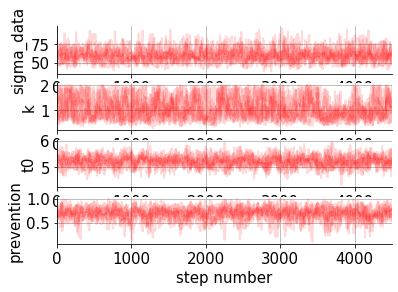

In [19]:
traceplot(samples=sampler.get_chain(discard=500),labels=["sigma_data","k","t0","prevention"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

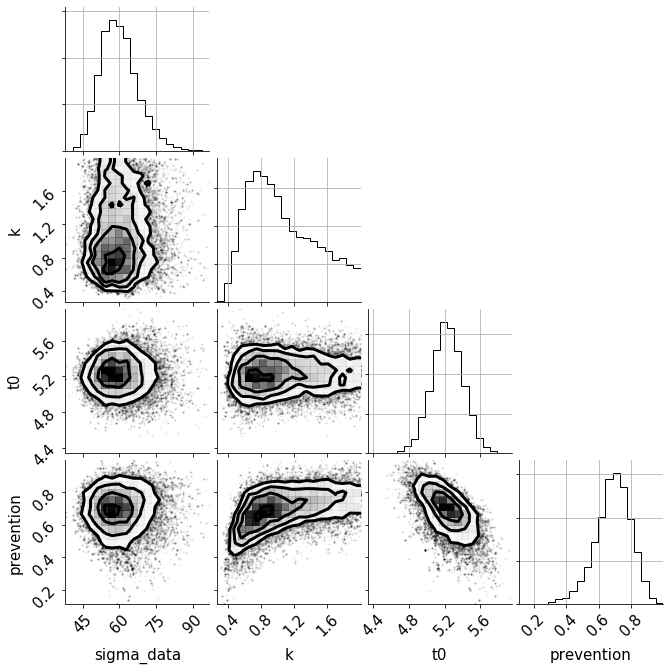

In [21]:
import corner

fig = corner.corner(
    flat_samples, labels=["sigma_data","k","t0","prevention"],
);

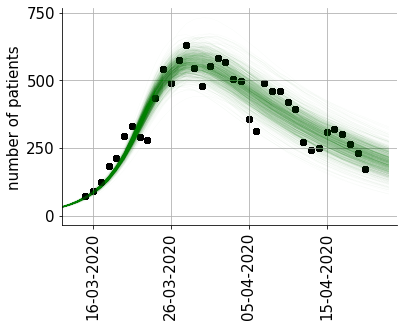

In [24]:
T = 3

fig,ax=plt.subplots()
for i in range(1000):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    model.parameters['k'] = np.random.choice(samples_dict['k'],1,replace=False)
    model.parameters['t0'] = np.random.choice(samples_dict['t0'],1,replace=False)
    prevention = np.random.choice(samples_dict['prevention'],1,replace=False)
    # Create checkpoints dictionary
    chk = {'time':  [lag_time], 
           'Nc':    [0.2*Nc_home + prevention*((1-0.70)*Nc_work + (1-0.80)*Nc_transport)],
          }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,start_date,lag_time,states,T=T,ax=ax,plt_kwargs={'linewidth': 0.25,'alpha': 0.05})

### Calibration of hospitalization parameters

Load the previously calibrated parameters: $\beta$, lag_time, k, t0, prevention

In [7]:
import json
with open('parameters.json', 'r') as fp:
    samples_dict = json.load(fp)

lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])
model.parameters['k'] = np.mean(samples_dict['k'])
model.parameters['t0'] = np.mean(samples_dict['t0'])
prevention = np.mean(samples_dict['prevention'])

In [14]:
# Create checkpoints dictionary
chk = {'time':  [lag_time], 
       'Nc':    [0.2*Nc_home + prevention*((1-0.70)*Nc_work + (1-0.80)*Nc_transport)],
      }

# define dataset
data=[df_sciensano["H_out"].values[:55],df_sciensano["ICU_tot"].values[:55],df_sciensano["H_tot_cumsum"].values[:55]]
# set optimisation settings
parNames = ['sigma_H_out','sigma_ICU_tot','sigma_H_tot','dc','dICU','dICUrec'] # must be a list!
states = [["H_out"],["ICU"],["H_tot"]]
bounds=((1,200),(1,300),(1,600),(8,30),(5,20),(2,20)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,checkpoints=chk,maxiter=100,popsize=100)

No constraints given.
Best after iteration 1: [101.18734319 183.10314419 424.02167273  15.66176037   8.9612895
   9.29937367] 918.1208052748257
Best after iteration 2: [101.18734319 183.10314419 424.02167273  15.66176037   8.9612895
   9.29937367] 918.1208052748257
Best after iteration 3: [101.18734319 183.10314419 424.02167273  15.66176037   8.9612895
   9.29937367] 918.1208052748257
New best for swarm at iteration 4: [132.17153097 165.78994791 251.54484466  16.23983892   7.65573407
  19.12534784] 912.0420269833646
Best after iteration 4: [132.17153097 165.78994791 251.54484466  16.23983892   7.65573407
  19.12534784] 912.0420269833646
Best after iteration 5: [132.17153097 165.78994791 251.54484466  16.23983892   7.65573407
  19.12534784] 912.0420269833646
New best for swarm at iteration 6: [117.7368667  159.62404386 321.67109983  14.63531308   9.12428887
  16.13324542] 905.6484615509788
Best after iteration 6: [117.7368667  159.62404386 321.67109983  14.63531308   9.12428887
  16.133

New best for swarm at iteration 45: [ 99.55372056  98.82958279 221.96741759  14.7590272    8.67374039
  20.        ] 885.3992295730184
Best after iteration 45: [ 99.55372056  98.82958279 221.96741759  14.7590272    8.67374039
  20.        ] 885.3992295730184
Best after iteration 46: [ 99.55372056  98.82958279 221.96741759  14.7590272    8.67374039
  20.        ] 885.3992295730184
New best for swarm at iteration 47: [ 99.5810861   98.98683215 221.81272931  14.76070304   8.68230654
  20.        ] 885.3991438095493
Best after iteration 47: [ 99.5810861   98.98683215 221.81272931  14.76070304   8.68230654
  20.        ] 885.3991438095493
New best for swarm at iteration 48: [ 99.4988398   98.81204349 221.93612994  14.76046172   8.67947488
  20.        ] 885.3990679912672
Best after iteration 48: [ 99.4988398   98.81204349 221.93612994  14.76046172   8.67947488
  20.        ] 885.3990679912672
New best for swarm at iteration 49: [ 99.75008514  98.63813084 221.73097221  14.7428035    8.682640

New best for swarm at iteration 87: [ 99.64876099  99.05023482 221.58190389  14.7462681    8.68082994
  20.        ] 885.3967274613652
Best after iteration 87: [ 99.64876099  99.05023482 221.58190389  14.7462681    8.68082994
  20.        ] 885.3967274613652
Best after iteration 88: [ 99.64876099  99.05023482 221.58190389  14.7462681    8.68082994
  20.        ] 885.3967274613652
Best after iteration 89: [ 99.64876099  99.05023482 221.58190389  14.7462681    8.68082994
  20.        ] 885.3967274613652
Best after iteration 90: [ 99.64876099  99.05023482 221.58190389  14.7462681    8.68082994
  20.        ] 885.3967274613652
Best after iteration 91: [ 99.64876099  99.05023482 221.58190389  14.7462681    8.68082994
  20.        ] 885.3967274613652
Best after iteration 92: [ 99.64876099  99.05023482 221.58190389  14.7462681    8.68082994
  20.        ] 885.3967274613652
Best after iteration 93: [ 99.64876099  99.05023482 221.58190389  14.7462681    8.68082994
  20.        ] 885.39672746136

In [15]:
model.parameters.update({
    'dc': theta[3],
    'dICU': theta[4],
    'dICUrec': theta[5],
}
)

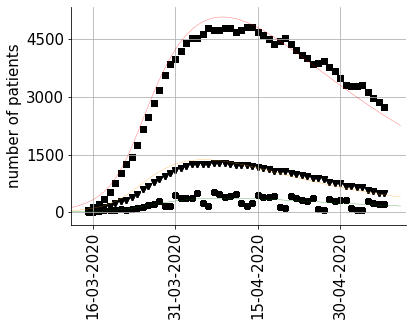

In [16]:
T = 3
fig,ax=plt.subplots()
for i in range(10):
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,plt_kwargs={'linewidth': 0.25,'alpha': 0.10})

In [18]:
pos = theta + [1,1,1, 0.1, 0.1, 0.1 ]* np.random.randn(12, 6)
bounds=((1,300),(1,400),(1,800),(1,30),(1,30),(1,30)) 
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,chk))
sampler.run_mcmc(pos, 3000, progress=True);

100%|██████████| 3000/3000 [1:13:58<00:00,  1.48s/it]


In [19]:
sampler.get_autocorr_time()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [ 72.67509203  97.71818996  80.65716742  80.39131981  80.61613348
 127.37394419]

In [20]:
samples = sampler.get_chain(discard=200,flat=False)
flat_samples = sampler.get_chain(discard=200,flat=True)

In [21]:
samples_dict.update({'dc': flat_samples[:,3].tolist(), 'dICU': flat_samples[:,4].tolist(),'dICUrec':flat_samples[:,5].tolist()})

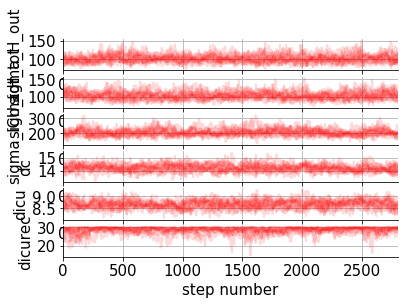

In [22]:
traceplot(samples=sampler.get_chain(discard=200),labels=["sigma_H_out","sigma H_tot","sigma_ICU_tot","dc","dicu","dicurec"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

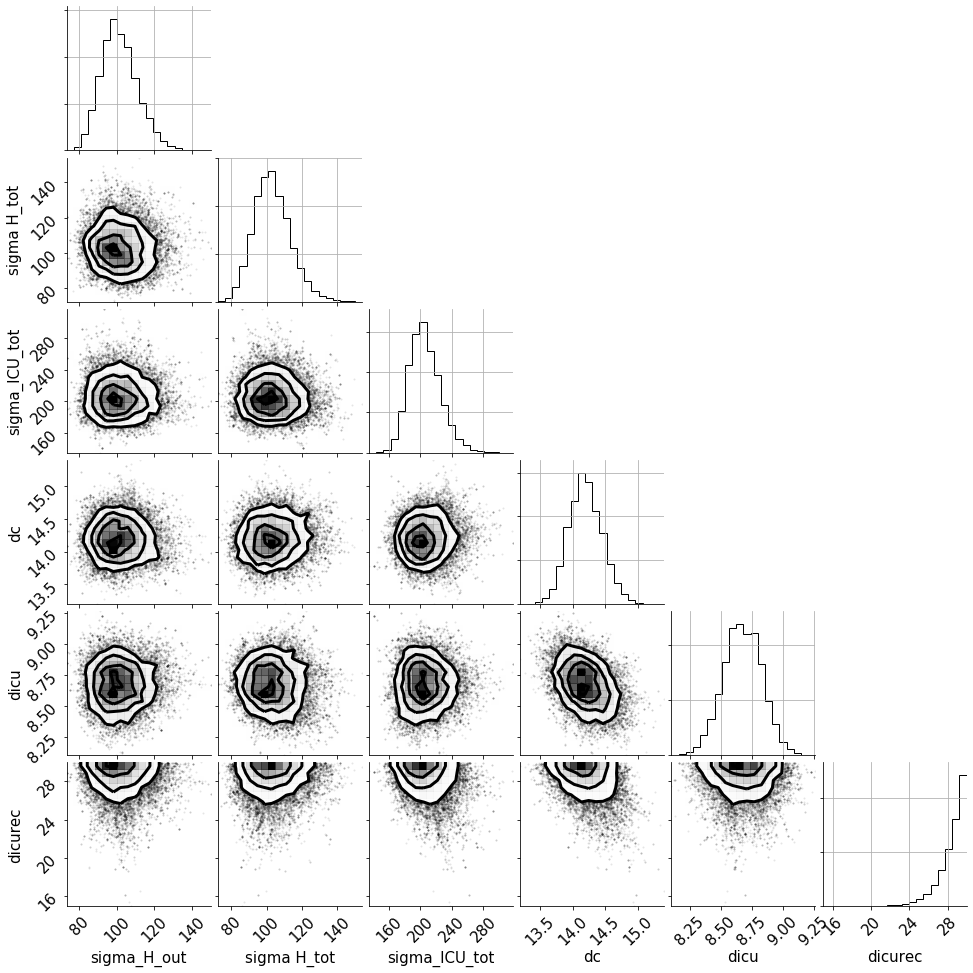

In [23]:
import corner

fig = corner.corner(
    flat_samples, labels=["sigma_H_out","sigma H_tot","sigma_ICU_tot","dc","dicu","dicurec"],
);

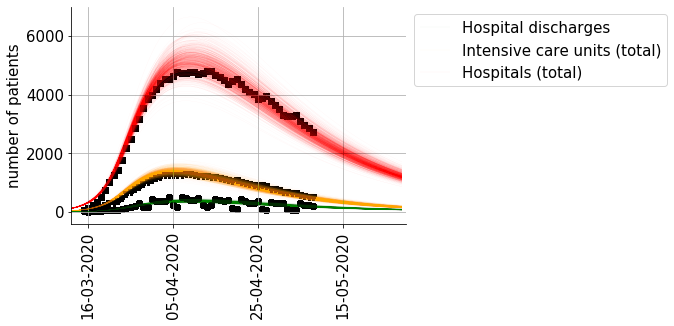

In [32]:
T = 21

fig,ax=plt.subplots()
for i in range(1000):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    model.parameters['k'] = np.random.choice(samples_dict['k'],1,replace=False)
    model.parameters['t0'] = np.random.choice(samples_dict['t0'],1,replace=False)
    prevention = np.random.choice(samples_dict['prevention'],1,replace=False)
    model.parameters['dc'] = np.random.choice(samples_dict['dc'],1,replace=False)
    model.parameters['dICU'] = np.random.choice(samples_dict['dICU'],1,replace=False)
    model.parameters['dICUrec'] = np.random.choice(samples_dict['dICUrec'],1,replace=False)
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,
                  legend_text=['Hospital discharges','Intensive care units (total)','Hospitals (total)'],
                  plt_kwargs={'linewidth': 0.25,'alpha': 0.05})

In [25]:
import json

with open('parameters.json', 'w') as fp:
    json.dump(samples_dict, fp)

# Notebook works till here

### Scenarios


Use the code snippet below to see the correspondence between `'t'` in the `pastPolicy` dictionary and the actual date.

In [ ]:
# Define data as a list containing data timeseries
data=[np.transpose(ICU_tot),np.transpose(H_tot)]
print(index[2],index[50],index[57],index[-1])

The interaction matrices of the 2008 study by Mossong were gathered under a business-as-usual scenario. It is thus not possible to use the interaction matrices without doing a correction for social distancing. Even when using only the interactions at home (`Nc_home`), the virus cannot be stopped.

In [ ]:
sigma = 1

Stringent measures were taken in the evening of March 17th, which corresponds to time-index 3, however, the measures are only 'enforced' on day 8 in the `pastPolicy` dictionary. Why? The change in human behaviour was very gradual, it took between 10-14 days after March 17th before everyone was working at home (see the Google mobility report). In other words, measures were taken on March 17th, but obedience for these measures was gradual, like a ramp. However, in the model we make a step-wise change. The obedience to measures can be adressed in future work.

Another important issue to adress is the home interaction matrix `Nc_home`. All contacts in these matrices are still assumed to be random, during a lockdown, the interactions at home should somehow be corrected for the 'bubble' effect. Since the average household size in belgium is 2 people, I correct the `Nc_home` matrix with a factor 1/2.

In [ ]:
sigma = 0.6

# Create a dictionary of past policies
pastPolicy = {'t':       [1,50,64], 
              'Nc':      [0.3*Nc_home+sigma*((1-0.70)*Nc_work+(1-0.70)*Nc_transport),
                          0.3*Nc_home+sigma*((1-0.30)*Nc_work+(1-0.40)*Nc_transport+(1-0.75)*Nc_schools),
                          0.3*Nc_home+sigma*((1-0.30)*Nc_work+(1-0.40)*Nc_transport+Nc_schools),
                         ]
              }

In [ ]:
# Create a dictionary of future policies
futurePolicy = {'t':     [21], # May 21th, June 4th 
                'Nc':    [0.3*Nc_home+sigma*((1-0.30)*Nc_work+(1-0.40)*Nc_transport)],
              }

In [ ]:
positions=[np.array([6]),np.array([5,6])]
# Run realTimeScenario
model.realTimeScenario(startdate,data,positions,pastPolicy,futurePolicy=futurePolicy,trace={'beta': [model.beta]},T_extra=124,
                       modelClr=['red','orange'],legendText=('ICU (model)','Hospital (model)','ICU (data)','Hospital (data)'),
                       titleText='Belgium',filename='test.svg')

Save your figures by altering the variable `filename = xxxxx.svg`!